In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,roc_curve,classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
# Optimized model implementations
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [2]:
# Load and preprocess data
def load_and_preprocess_data(file_path):
    # Load the data
    df = pd.read_csv(file_path)
    
    # Separate features and target
    X = df.drop('Label', axis=1).values
    y = df['Label'].values
    
    print('X shape:', X.shape)
    print('y shape:', y.shape)
    
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Reshape input for RNN models (samples, timesteps, features)
    X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    
    return X_train_reshaped, X_test_reshaped, y_train, y_test


In [3]:
# Define RNN model
def create_rnn_model(input_shape):
    model = Sequential([
        SimpleRNN(64, input_shape=input_shape),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [4]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(128, input_shape=input_shape),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', 
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])
    return model

In [5]:
def build_gru_model(input_shape):
    model = Sequential([
        GRU(128, input_shape=input_shape),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', 
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])
    return model

In [6]:
 # Training and Evaluation Function
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes)
    auc = roc_auc_score(y_test, y_pred)

     # Print classification report
      # Print classification report
    classification_rep = classification_report(y_test, y_pred_classes)
    print(f'{model_name} - Classification Report:')
    print(classification_rep)
    
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

     # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc,
        'classification_report': classification_rep
    }


In [7]:

def save_results_to_txt(results, filename='model_results.txt'):
    """
    Save model evaluation results to a text file
    """
    with open(filename, 'w') as f:
        # Write timestamp
        f.write(f"Model Evaluation Results")
        f.write("="*50 + "\n\n")
        
        # Write results for each model
        for model_name, metrics in results.items():
            f.write(f"{model_name} Model Results:\n")
            f.write("-"*20 + "\n")
            for metric, value in metrics.items():
                f.write(f"{metric:<15}: {value:.4f}\n")
            f.write("\n")
        
        # Write best model for each metric
        f.write("Best Models by Metric:\n")
        f.write("-"*20 + "\n")
        
        # Convert results to DataFrame for easy comparison
        results_df = pd.DataFrame(results)
        for metric in results_df.index:
            best_model = results_df.loc[metric].idxmax()
            best_value = results_df.loc[metric].max()
            f.write(f"{metric:<15}: {best_model} ({best_value:.4f})\n")


X shape: (52466, 50)
y shape: (52466,)
X_train shape:  (41972, 1, 50)
X_test shape:  (10494, 1, 50)
y_train shape:  (41972,)
y_test shape:  (10494,)
Training RNN Model...
Epoch 1/50


c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1050/1050 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9933 - loss: 0.0478 - val_accuracy: 0.9993 - val_loss: 0.0021
Epoch 2/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9997 - loss: 0.0011 - val_accuracy: 0.9993 - val_loss: 0.0019
Epoch 3/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9998 - loss: 8.2015e-04 - val_accuracy: 0.9994 - val_loss: 0.0017
Epoch 4/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9999 - loss: 5.0909e-04 - val_accuracy: 0.9994 - val_loss: 0.0021
Epoch 5/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9999 - loss: 1.7535e-04 - val_accuracy: 0.9994 - val_loss: 0.0019
Epoch 6/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 1.0000 - loss: 8.0696e-05 - val_accuracy: 0.9994 - val_loss: 0.0023
Epoch 7/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9999 - loss: 3.4176e-04 - val_accuracy: 0.9994 - val_loss: 0.0022
Epoch 8/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 1.0000 - loss: 

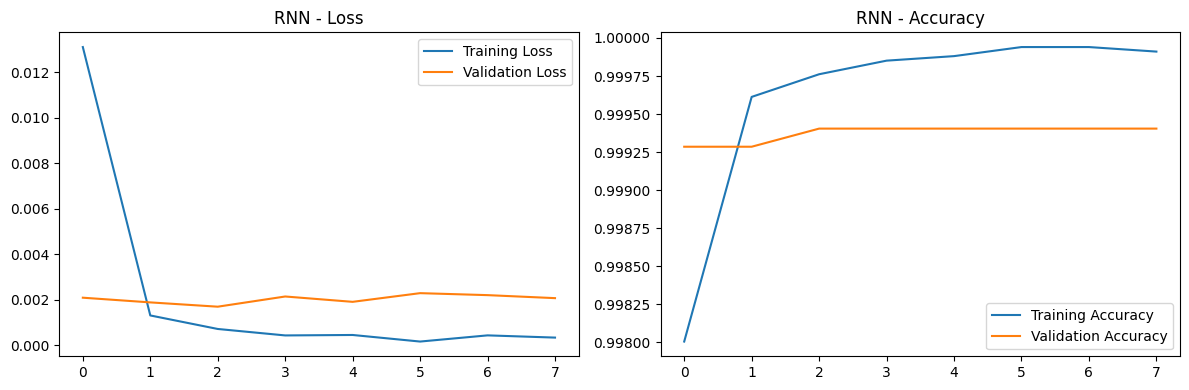

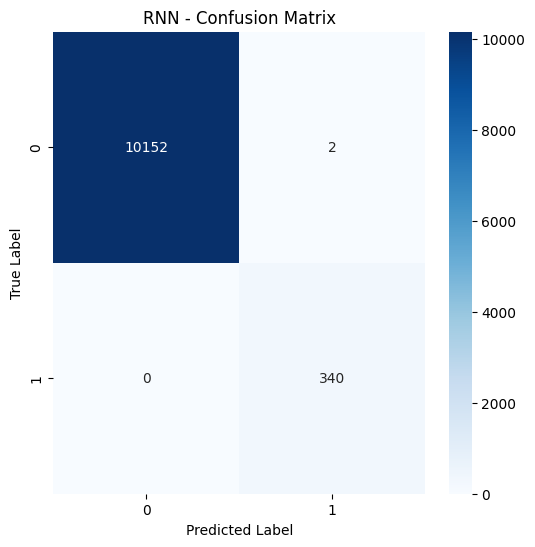

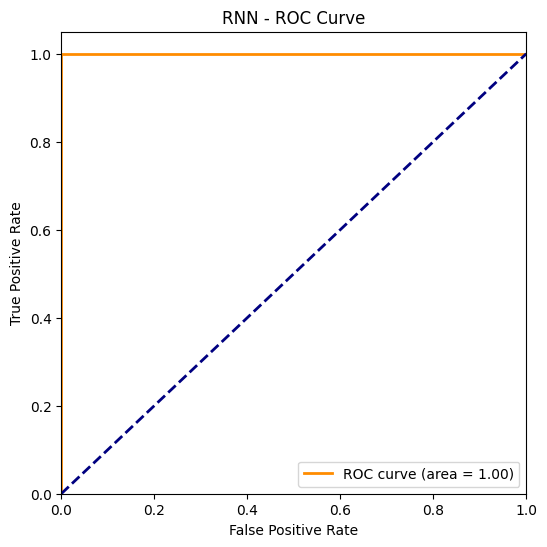


Training LSTM Model...
Epoch 1/50


c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1050/1050 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9778 - loss: 0.1004 - val_accuracy: 0.9994 - val_loss: 0.0027
Epoch 2/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9996 - loss: 0.0015 - val_accuracy: 0.9993 - val_loss: 0.0035
Epoch 3/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9994 - loss: 0.0017 - val_accuracy: 0.9994 - val_loss: 0.0026
Epoch 4/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9999 - loss: 7.9726e-04 - val_accuracy: 0.9993 - val_loss: 0.0037
Epoch 5/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9997 - loss: 0.0012 - val_accuracy: 0.9993 - val_loss: 0.0033
Epoch 6/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9997 - loss: 4.9559e-04 - val_accuracy: 0.9994 - val_loss: 0.0028
Epoch 7/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9997 - loss: 0.0011 - val_accuracy: 0.9994 - val_loss: 0.0033
Epoch 8/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9999 - loss: 4.7992e-04 -

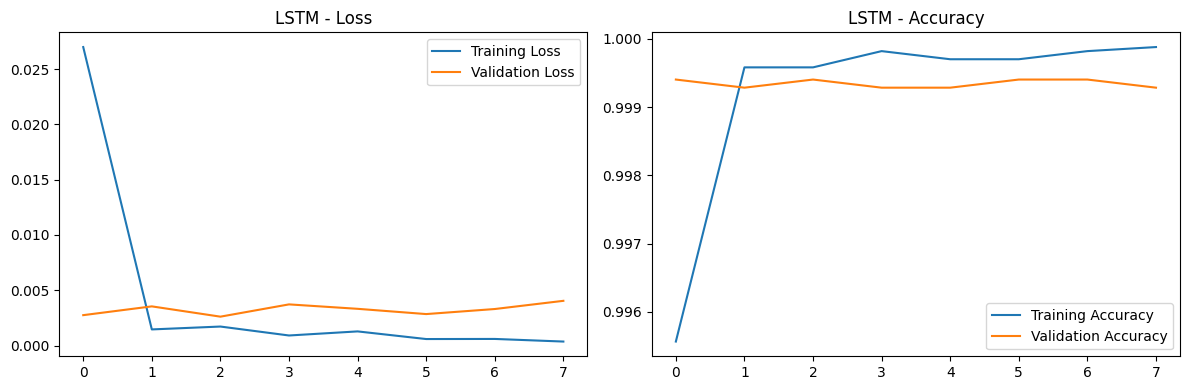

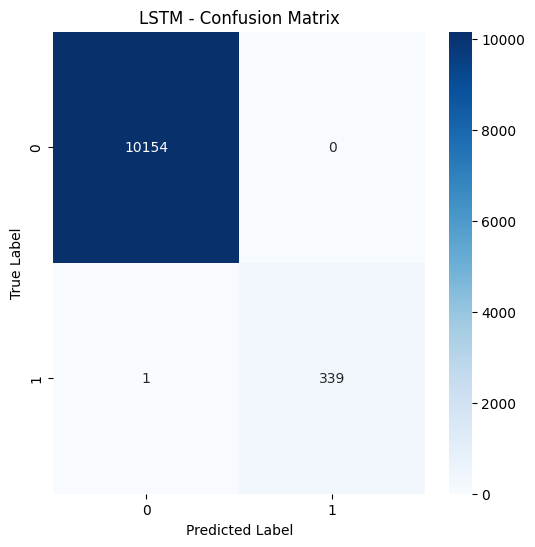

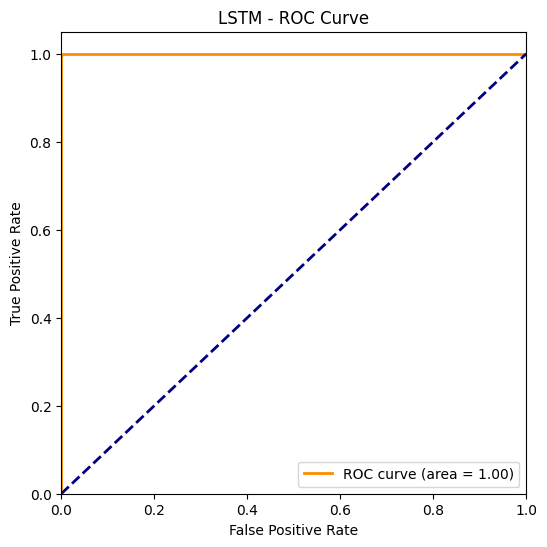


Training GRU Model...
Epoch 1/50


c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1050/1050 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9858 - loss: 0.0622 - val_accuracy: 0.9993 - val_loss: 0.0024
Epoch 2/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9998 - loss: 0.0010 - val_accuracy: 0.9994 - val_loss: 0.0026
Epoch 3/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9998 - loss: 0.0010 - val_accuracy: 0.9995 - val_loss: 0.0025
Epoch 4/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9998 - loss: 4.5837e-04 - val_accuracy: 0.9994 - val_loss: 0.0035
Epoch 5/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9997 - loss: 9.8892e-04 - val_accuracy: 0.9992 - val_loss: 0.0036
Epoch 6/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9997 - loss: 9.3864e-04 - val_accuracy: 0.9994 - val_loss: 0.0036
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
GRU - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10154
           1       1.00      1.00      1

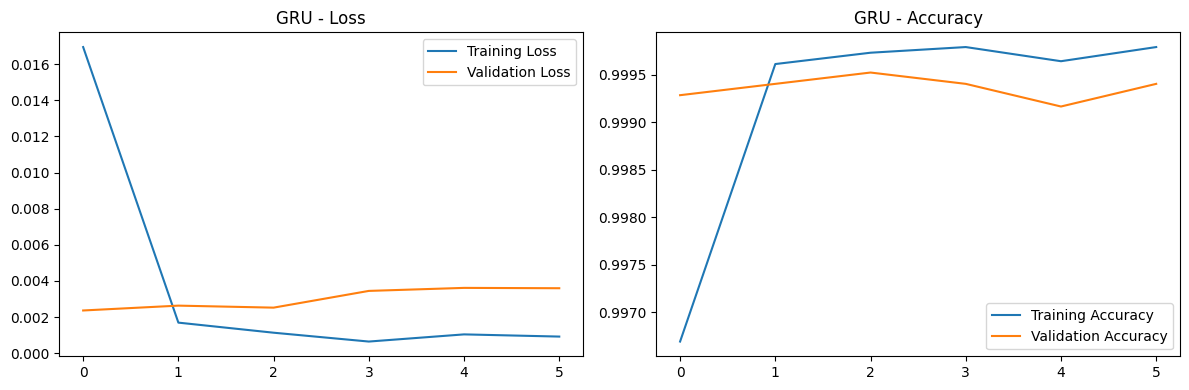

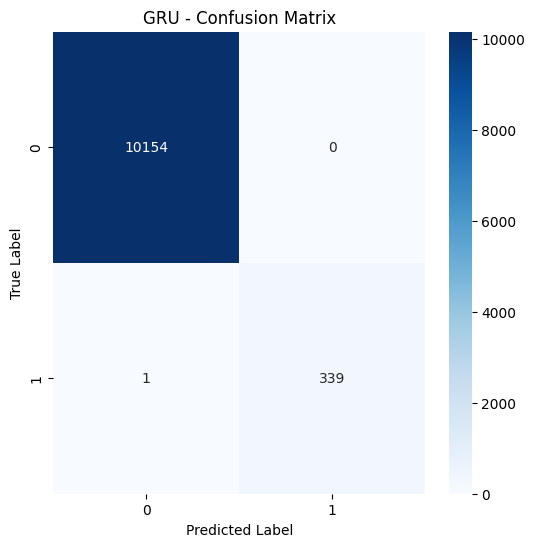

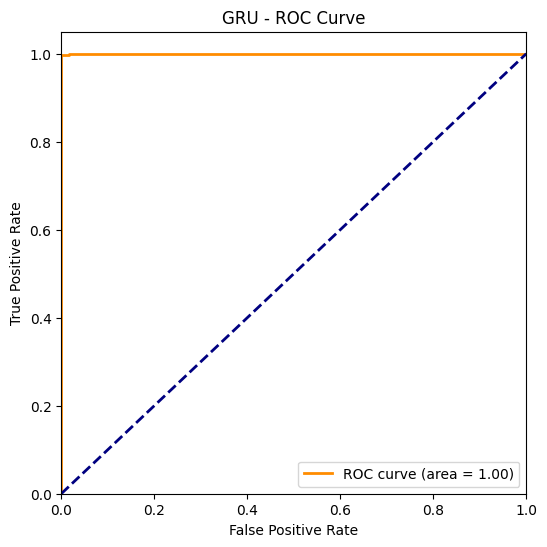


Model Comparison:
                                                                     RNN  \
accuracy                                                        0.999809   
precision                                                       0.994152   
recall                                                               1.0   
f1_score                                                        0.997067   
auc                                                                  1.0   
classification_report                precision    recall  f1-score   ...   

                                                                    LSTM  \
accuracy                                                        0.999905   
precision                                                            1.0   
recall                                                          0.997059   
f1_score                                                        0.998527   
auc                                                             0.99

In [8]:

# Cell 4: Main Execution
if __name__ == "__main__":
    # Load and preprocess data
    X_train, X_test, y_train, y_test = load_and_preprocess_data('processed_features.csv')

    print("X_train shape: ", X_train.shape)
    print("X_test shape: ", X_test.shape)
    print("y_train shape: ", y_train.shape)
    print("y_test shape: ", y_test.shape)
    
    # Get input shape
    input_shape = (1, X_train.shape[2])
    
    # Dictionary to store results
    results = {}
    
    # Train and evaluate RNN
    print("Training RNN Model...")
    rnn_model = create_rnn_model(input_shape)
    results['RNN'] = train_and_evaluate_model(rnn_model, X_train, X_test, y_train, y_test, 'RNN')
    
    # Train and evaluate LSTM
    print("\nTraining LSTM Model...")
    lstm_model = build_lstm_model(input_shape)
    results['LSTM'] = train_and_evaluate_model(lstm_model, X_train, X_test, y_train, y_test, 'LSTM')
    
    # Train and evaluate GRU
    print("\nTraining GRU Model...")
    gru_model = build_gru_model(input_shape)
    results['GRU'] = train_and_evaluate_model(gru_model, X_train, X_test, y_train, y_test, 'GRU')
    
    # Compare results
    results_df = pd.DataFrame(results).round(4)
    print("\nModel Comparison:")
    print(results_df)
    


     # Save comprehensive results to text file
    with open('model_results.txt', 'w') as f:
        # Write timestamp
        f.write(f"Model Evaluation Results-RNN,LSTM,GRU")
        f.write("="*50 + "\n\n")
        
       
        
       
        # Write detailed results for each model
        f.write("Detailed Results by Model:\n")
        f.write("="*50 + "\n\n")
        
        for model_name, metrics in results.items():
            f.write(f"{model_name} Model Results:\n")
            f.write("-"*20 + "\n")
            for metric, value in metrics.items():
                if metric == 'classification_report':
                    f.write(f"\nClassification Report:\n{value}\n")
                elif isinstance(value, (int, float)):
                    f.write(f"{metric:<15}: {value:.4f}\n")
            f.write("\n")



